In [ ]:
# 구글드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')
# change directory
%cd '/content/drive/MyDrive/연구실/Deep Learning from scratch 1/deep-learning-from-scratch'

Mounted at /content/drive
/content/drive/MyDrive/연구실/Deep Learning from scratch 1/deep-learning-from-scratch


# 최적화
손실 함수의 값이 최소가 되게 하는 매개변수를 결정하는 과정

**SGD** : 확률적 경사 하강법
> $W\leftarrow W-\eta\frac{\partial L}{\partial W}$
- 기울기에 대한 비등방성 함수에서 비효율적인 최적화 경로

In [ ]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
    
    # 매개변수의 값 딕셔너리와 기울기 딕셔너리를 입력하면 매개변수의 값을 갱신
    def update(self, params, grads): 
        for key in params.keys():
            params[key] -= self.lr * grads[key]

**Momentum** : 모멘텀 (물리학의 운동량)
> $v\leftarrow\alpha v-\eta\frac{\partial L}{\partial W}$  
$W\leftarrow W+v$
- 기울기 방향에 대응되는 가속도 존재

In [ ]:
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
    
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
        
        for key in params.keys():
            self.v[key] = self.momentum * self.v[key] - self.lr * self.grads[key]
            params[key] += self.v[key]

**AdaGrad** : 매개변수 및 그 원소별 적응적(adaptive) 학습률 조정 ; 크게 갱신된 원소의 학습률 감소
> $h\leftarrow h+\frac{\partial L}{\partial W}\odot\frac{\partial L}{\partial W}$ (단, $\odot$은 행렬의 원소별 곱)  
$W\leftarrow W-\eta\frac{1}{\sqrt h}\frac{\partial L}{\partial W}$
- $h$ 값에 과거의 모든 기울기의 제곱이 합으로 반영되어 갱신량이 0이 되는 문제
 - RMSProp : $h$ 값 계산을 지수이동평균 방식으로 개선

In [ ]:
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
    
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
        
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

**Adam** : AdaGrad와 Momentum의 융합 및 지수이동평균 방식
> [Adam] http://arxiv.org/abs/1412.6980v8

In [ ]:
class Adam:
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)         
        
        for key in params.keys():
            # self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            # self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)

전반적으로 SGD에 비해 Momentum, AdaGrad, Adam의 학습 효율이 높음
- 단, 각 optimizer의 하이퍼파라미터(학습률 등), 신경망의 구조(층 깊이 등)에 따라 결과가 달라짐  
$\rightarrow$ 상황에 따라 다양한 시도를 통해 적절한 optimizer 채택 

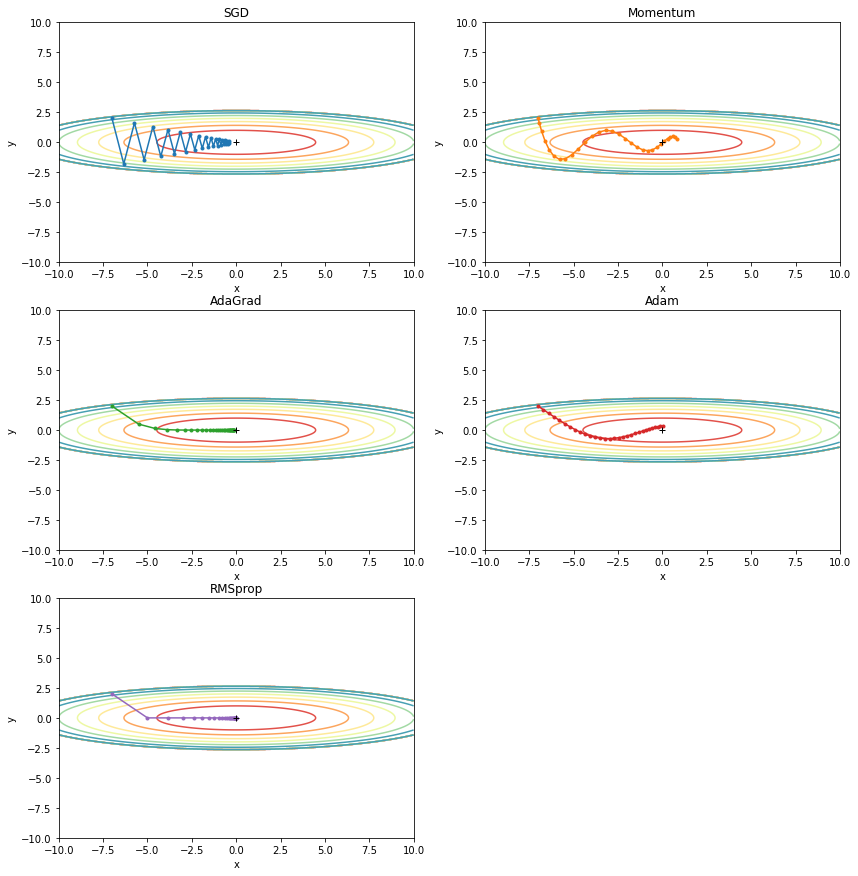

In [ ]:
# 갱신 방법(optimizer)별 최적화 경로 비교 시각화 예시
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from common.optimizer import *

# 손실 함수
def f(x, y):
    return x**2 / 20.0 + y**2
# 손실 함수의 gradient
def df(x, y):
    return x / 10.0, 2.0*y

init_pos = (-7.0, 2.0) # 시작 위치
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0

optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.95)
optimizers["Momentum"] = Momentum(lr=0.1)
optimizers["AdaGrad"] = AdaGrad(lr=1.5)
optimizers["Adam"] = Adam(lr=0.3)
optimizers['RMSprop'] = RMSprop(lr=0.2)

idx = 1 # 그래프 인덱스
G = plt.figure(figsize=(14,15))

for key in optimizers: # 각 optimizer마다,
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]
    for i in range(30): # 30회 갱신
        x_history.append(params['x']) # x좌표 자취
        y_history.append(params['y']) # y좌표 자취
        grads['x'], grads['y'] = df(params['x'], params['y']) # 기울기
        optimizer.update(params, grads) # 매개변수 값 갱신
    
    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    # 외곽선 단순화
    mask = Z>7
    Z[mask] = 0
    
    # 그래프 그리기
    ax = G.add_subplot(3, 2, idx)
    ax.plot(x_history, y_history, '.-', color=['tab:blue','tab:orange','tab:green','tab:red','tab:purple'][idx-1])
    idx += 1
    ax.contour(X, Y, Z, cmap='Spectral') # 등고선
    ax.set_ylim(-10, 10)
    ax.set_xlim(-10, 10)
    ax.plot(0, 0, '+', color='k') # 원점 표시
    ax.set_title(key)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
plt.show()

In [ ]:
# MNIST 데이터셋에서 optimizer별 학습 진도 비교 
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import *
from tqdm import tqdm

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)
train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000

optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100], output_size=10)
    train_loss[key] = []    

# 훈련 시작
for i in tqdm(range(max_iterations)):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i%100==0: # 100회 갱신마다 optimizer별 손실 출력
        print("===========" + f"iteration : {i}" + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + " : " + str(loss))

  0%|          | 1/2000 [00:00<06:46,  4.92it/s]

===========iteration : 0===========
SGD : 2.3868696038363786
Momentum : 2.3246485154832413
AdaGrad : 1.9271489001627855
Adam : 2.1565607898928203
RMSprop : 13.850671688179148


  5%|▌         | 103/2000 [00:10<01:38, 19.18it/s]

===========iteration : 100===========
SGD : 1.6063100401983204
Momentum : 0.24534937730670672
AdaGrad : 0.10334110178253841
Adam : 0.2102754184788877
RMSprop : 0.2775489134896413


 10%|█         | 202/2000 [00:20<05:35,  5.36it/s]

===========iteration : 200===========
SGD : 0.8308838432611988
Momentum : 0.29792851467426906
AdaGrad : 0.07855239556328467
Adam : 0.1584814180525787
RMSprop : 0.2754833046739781


 15%|█▌        | 304/2000 [00:26<01:24, 20.09it/s]

===========iteration : 300===========
SGD : 0.5405618427106386
Momentum : 0.2995321147947631
AdaGrad : 0.1461166722241759
Adam : 0.1822073271224383
RMSprop : 0.22826648950347636


 20%|██        | 402/2000 [00:31<02:18, 11.55it/s]

===========iteration : 400===========
SGD : 0.2878630123656606
Momentum : 0.1671748500227173
AdaGrad : 0.07708412413207047
Adam : 0.11434101031539058
RMSprop : 0.05590693195694463


 25%|██▌       | 502/2000 [00:38<01:20, 18.62it/s]

===========iteration : 500===========
SGD : 0.3178764895496461
Momentum : 0.16082636011168827
AdaGrad : 0.06212922947101131
Adam : 0.09395186463251481
RMSprop : 0.1253935961739379


 30%|███       | 603/2000 [00:43<01:20, 17.30it/s]

===========iteration : 600===========
SGD : 0.34340040512829767
Momentum : 0.10321127013310362
AdaGrad : 0.04926740075683103
Adam : 0.05667535983036443
RMSprop : 0.05221132953109092


 35%|███▌      | 702/2000 [00:51<01:12, 17.86it/s]

===========iteration : 700===========
SGD : 0.3180127885851019
Momentum : 0.1534664067420896
AdaGrad : 0.07625724812350756
Adam : 0.06671457653187647
RMSprop : 0.09757928414399057


 40%|████      | 804/2000 [00:56<01:00, 19.72it/s]

===========iteration : 800===========
SGD : 0.45735203453510304
Momentum : 0.19758024537510951
AdaGrad : 0.07355890787366436
Adam : 0.17474354657219338
RMSprop : 0.10564816404162031


 45%|████▌     | 901/2000 [01:10<02:45,  6.63it/s]

===========iteration : 900===========
SGD : 0.2654925618838492
Momentum : 0.07873965550616385
AdaGrad : 0.03624227619901973
Adam : 0.05697391532044416
RMSprop : 0.05266016589916145


 50%|█████     | 1003/2000 [01:22<00:56, 17.75it/s]

===========iteration : 1000===========
SGD : 0.2276426466747804
Momentum : 0.12423594955619516
AdaGrad : 0.07693934498772734
Adam : 0.07805205841022209
RMSprop : 0.06865161020355665


 55%|█████▌    | 1104/2000 [01:27<00:44, 20.00it/s]

===========iteration : 1100===========
SGD : 0.4043411957374752
Momentum : 0.207861023627598
AdaGrad : 0.06761829675022145
Adam : 0.115703034512673
RMSprop : 0.17071640145380068


 60%|██████    | 1202/2000 [01:35<01:06, 11.98it/s]

===========iteration : 1200===========
SGD : 0.1746758706688572
Momentum : 0.08457086715755226
AdaGrad : 0.020711311046995556
Adam : 0.02983031656658211
RMSprop : 0.031612037245723125


 65%|██████▌   | 1301/2000 [01:43<01:05, 10.60it/s]

===========iteration : 1300===========
SGD : 0.31375384251485117
Momentum : 0.07907040594762821
AdaGrad : 0.038199333060581195
Adam : 0.03331436669926344
RMSprop : 0.1798777715946414


 70%|███████   | 1404/2000 [01:57<00:31, 18.94it/s]

===========iteration : 1400===========
SGD : 0.17797122223748546
Momentum : 0.03340310012782508
AdaGrad : 0.011953343715123552
Adam : 0.024056883041103243
RMSprop : 0.032774707083283366


 75%|███████▌  | 1502/2000 [02:07<01:03,  7.81it/s]

===========iteration : 1500===========
SGD : 0.23550889444772416
Momentum : 0.10489511557472678
AdaGrad : 0.02990788934951534
Adam : 0.04470889092640967
RMSprop : 0.12447989039361676


 80%|████████  | 1604/2000 [02:13<00:21, 18.13it/s]

===========iteration : 1600===========
SGD : 0.1673598283463238
Momentum : 0.09498571516309355
AdaGrad : 0.03721096563096148
Adam : 0.08505610659374233
RMSprop : 0.07575474125490556


 85%|████████▌ | 1703/2000 [02:24<00:22, 13.20it/s]

===========iteration : 1700===========
SGD : 0.2287433653762714
Momentum : 0.12770416112799704
AdaGrad : 0.05985708754869293
Adam : 0.036476641490913425
RMSprop : 0.08910233384840328


 90%|█████████ | 1804/2000 [02:29<00:10, 18.08it/s]

===========iteration : 1800===========
SGD : 0.20448212374450492
Momentum : 0.024249502000170085
AdaGrad : 0.013331896171094997
Adam : 0.013663474030505432
RMSprop : 0.030182111544308818


 95%|█████████▌| 1904/2000 [02:37<00:05, 18.18it/s]

===========iteration : 1900===========
SGD : 0.16486122224910993
Momentum : 0.04661167496680588
AdaGrad : 0.02422607452077944
Adam : 0.037202066975460475
RMSprop : 0.042565420282525704


100%|██████████| 2000/2000 [02:42<00:00, 12.28it/s]


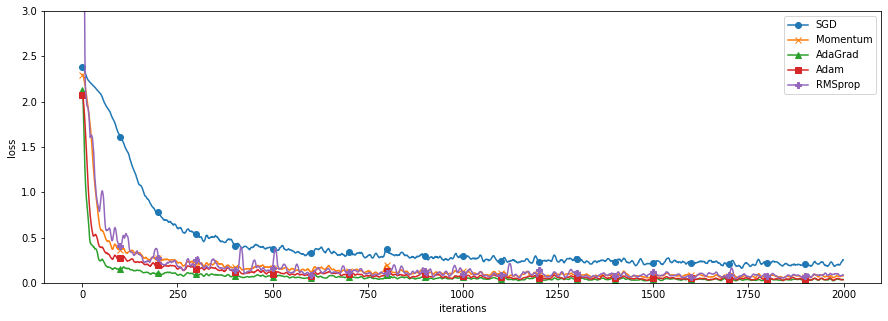

In [ ]:
# 학습 진도 비교 그래프
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "^", "Adam": "s", "RMSprop": "P"}
x = np.arange(max_iterations)
plt.figure(figsize=(15,5))
for key in optimizers.keys(): # markevery : 마커 표시 간격
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0,3)
plt.legend()
plt.show()

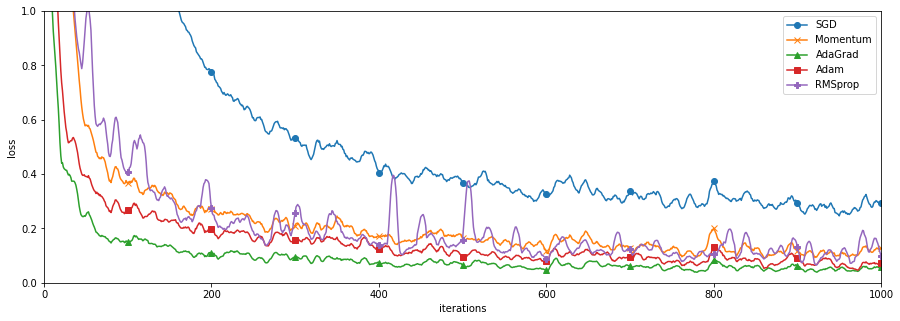

In [ ]:
# 확대
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "^", "Adam": "s", "RMSprop": "P"}
x = np.arange(max_iterations)
plt.figure(figsize=(15,5))
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.xlim(0,1000)
plt.ylabel("loss")
plt.ylim(0,1)
plt.legend()
plt.show()

In [ ]:
# 테스트 정확도 비교
my_x = x_test[::100]
my_t = t_test[::100]

for key in optimizers.keys():
    print(key, ':', networks[key].accuracy(my_x, my_t))

SGD : 0.89
Momentum : 0.96
AdaGrad : 0.95
Adam : 0.95
RMSprop : 0.95


# 가중치 초기화

**가중치 초기화 설정** : 적절한 표준편차의 랜덤 값으로 초기화해야 함
- 동일한 값으로 초기화  
$\rightarrow$ 여러 가중치를 사용하는 것이 무의미
- 활성화값의 밀집 현상  
$\rightarrow$ 표현력 제한(여러 노드를 사용하는 것이 무의미), 기울기 소실(ex. 활성화 함수가 sigmoid일 때 0과 1로 밀집되는 경우)

$\star$ 신경망 학습의 효율성을 위해, 서로 다른 층 간에 적당히 다양한 데이터가 흐르도록 가중치를 초기화
1. **Xavier 초깃값** : 표준편차가 이전 층 노드 수 제곱근의 역수인 정규분포에서 랜덤 추출
 - 활성화 함수가 **sigmoid, tanh**인 경우 사용
2. **He 초깃값** : 표준편차가 Xavier 초깃값 표준편차의 2배가 되도록 정규분포에서 랜덤 추출
 - 활성화 함수가 **ReLU**인 경우 사용

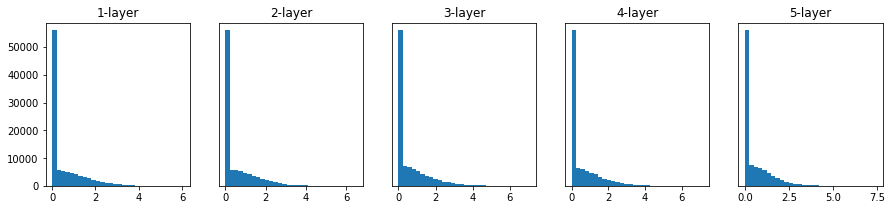

In [ ]:
# 가중치 초기화 설정에 따른 은닉층 활성화값 변화 실험
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
def ReLU(x):
    return np.maximum(0, x)
def tanh(x):
    return np.tanh(x)
    
input_data = np.random.randn(1000, 100) # 100개의 특성을 갖는 데이터 샘플 1000개
node_num = 100 # 각 은닉층의 노드 수
hidden_layer_size = 5 # 은닉층 5개
activations = {}

x = input_data

for i in range(hidden_layer_size):
    if i!=0:
        x = activations[i-1]

    # 가중치 초기화 설정 ; 초깃값의 표준편차를 바꿔 실험
    # w = np.random.randn(node_num, node_num) * 1 # sigmoid인 경우 활성화값이 0과 1에 밀집되어 기울기 소실
    # w = np.random.randn(node_num, node_num) * 0.01 # sigmoid인 경우 활성화값이 0.5에 밀집되어 표현력 제한
    # w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num) # Xavier 초깃값 : sigmoid, tanh
    w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num) # He 초깃값 : ReLU

    a = np.dot(x, w)

    # 활성화 함수 설정
    # z = sigmoid(a)
    z = ReLU(a)
    # z = tanh(a) # Xavier 초깃값에서 sigmoid인 경우 층이 깊어지면서 활성화값의 분포가 일그러지는 현상을 보완

    activations[i] = z

# 히스토그램 그리기
plt.figure(figsize=(15, 3))
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + '-layer')
    if i!=0:
        plt.yticks([], [])
    plt.hist(a.flatten(), bins=30)
plt.show()

In [ ]:
# MNIST 데이터셋에서 가중치 초기화 설정에 따른 신경망 학습 비교
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD
from tqdm import tqdm
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)
train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000
optimizer = SGD(lr=0.01)

# 가중치 초기화 설정별 5층 신경망(활성화 함수 : ReLU) 구축
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100], output_size=10,
                                  weight_init_std=weight_type) # 가중치 초깃값의 표준편차 ; 문자열인 경우 'sigmoid'이면 Xavier 방식, 'relu'이면 He 방식 채택
    train_loss[key] = []

# 훈련 시작
for i in tqdm(range(max_iterations)):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i%100==0: # 100회 갱신마다 가중치 초기화 설정별 손실 출력
        print("===========" + "iteration : " + str(i) + "===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + " : " + str(loss))

  0%|          | 6/2000 [00:00<01:12, 27.49it/s]

===========iteration : 0===========
std=0.01 : 2.302478755525721
Xavier : 2.3077893331293597
He : 2.557598545617813


  5%|▌         | 101/2000 [00:05<01:22, 22.97it/s]

===========iteration : 100===========
std=0.01 : 2.3015687908852325
Xavier : 2.2500772465876517
He : 1.482956809411962


 10%|█         | 207/2000 [00:09<00:54, 32.67it/s]

===========iteration : 200===========
std=0.01 : 2.3014886771436
Xavier : 2.0751783997593893
He : 0.6918195190127289


 15%|█▌        | 307/2000 [00:12<00:49, 34.45it/s]

===========iteration : 300===========
std=0.01 : 2.3038963238803687
Xavier : 1.834690268291125
He : 0.5107285137933437


 20%|██        | 407/2000 [00:15<00:46, 34.14it/s]

===========iteration : 400===========
std=0.01 : 2.3036503217515225
Xavier : 1.33460713486273
He : 0.5292061617106252


 25%|██▌       | 503/2000 [00:20<01:12, 20.70it/s]

===========iteration : 500===========
std=0.01 : 2.2984062196587365
Xavier : 0.875484875750356
He : 0.35381931422918567


 30%|███       | 607/2000 [00:24<00:41, 33.94it/s]

===========iteration : 600===========
std=0.01 : 2.299794258119236
Xavier : 0.6798604438116205
He : 0.2822017194894765


 35%|███▌      | 703/2000 [00:26<00:42, 30.32it/s]

===========iteration : 700===========
std=0.01 : 2.3017677538811734
Xavier : 0.48335534749638964
He : 0.22592801830124135


 40%|████      | 807/2000 [00:29<00:34, 34.27it/s]

===========iteration : 800===========
std=0.01 : 2.2977200559243367
Xavier : 0.40401057286471875
He : 0.22901503198961404


 45%|████▌     | 904/2000 [00:36<01:05, 16.77it/s]

===========iteration : 900===========
std=0.01 : 2.2957934094190318
Xavier : 0.28842485876387036
He : 0.18368035937284133


 50%|█████     | 1002/2000 [00:41<01:30, 11.03it/s]

===========iteration : 1000===========
std=0.01 : 2.304088670169012
Xavier : 0.5287494299038729
He : 0.30215592834969784


 55%|█████▌    | 1103/2000 [00:48<00:52, 17.24it/s]

===========iteration : 1100===========
std=0.01 : 2.2996504480685287
Xavier : 0.35601827195981656
He : 0.20736528639432075


 60%|██████    | 1207/2000 [00:54<00:22, 35.73it/s]

===========iteration : 1200===========
std=0.01 : 2.2936186215661936
Xavier : 0.5792715466142242
He : 0.3962849080116504


 65%|██████▌   | 1308/2000 [00:57<00:19, 36.27it/s]

===========iteration : 1300===========
std=0.01 : 2.3028429289781305
Xavier : 0.3200573466969935
He : 0.2310891448651327


 70%|███████   | 1408/2000 [01:00<00:16, 36.17it/s]

===========iteration : 1400===========
std=0.01 : 2.295630431435964
Xavier : 0.31171134455236277
He : 0.23819161001287284


 75%|███████▌  | 1503/2000 [01:05<00:33, 15.05it/s]

===========iteration : 1500===========
std=0.01 : 2.3034413245083254
Xavier : 0.32950268629642143
He : 0.22776996244791442


 80%|████████  | 1603/2000 [01:08<00:11, 35.53it/s]

===========iteration : 1600===========
std=0.01 : 2.3060862238912065
Xavier : 0.2148209857162125
He : 0.18170571380707276


 85%|████████▌ | 1707/2000 [01:11<00:08, 32.93it/s]

===========iteration : 1700===========
std=0.01 : 2.301165327326804
Xavier : 0.4215675515399552
He : 0.29742945053504954


 90%|█████████ | 1804/2000 [01:15<00:13, 14.78it/s]

===========iteration : 1800===========
std=0.01 : 2.3091954413832614
Xavier : 0.2404139694952312
He : 0.1598593070835339


 95%|█████████▌| 1905/2000 [01:21<00:03, 28.24it/s]

===========iteration : 1900===========
std=0.01 : 2.2953176992967164
Xavier : 0.31878581427195263
He : 0.23706163922587137


100%|██████████| 2000/2000 [01:28<00:00, 22.66it/s]


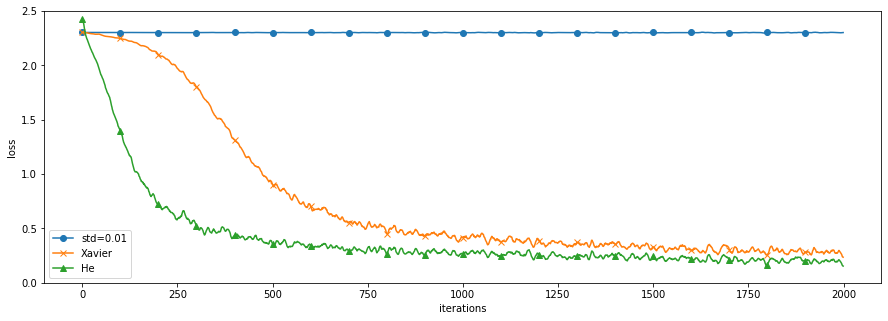

In [ ]:
# 학습 진도 비교 그래프
markers = {'std=0.01': 'o', 'Xavier': 'x', 'He': '^'}
x = np.arange(max_iterations)
plt.figure(figsize=(15, 5))
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()
# 가중치 초깃값의 표준편차를 0.01로 한 경우, 순전파의 활성화값이 대부분 0 근처로 밀집되어 역전파의 기울기가 작아지면서 가중치 갱신(학습)이 되지 않음
# Xavier, He 초깃값을 사용한 경우, 학습이 순조롭게 진행
# 활성화 함수가 ReLU이므로 He 초깃값에서 보다 효율적으로 학습

In [ ]:
# 테스트 정확도 비교
my_x = x_test[::100]
my_t = t_test[::100]

for key in weight_init_types.keys():
    print(key, ':', networks[key].accuracy(my_x, my_t))

std=0.01 : 0.1
Xavier : 0.88
He : 0.9


# 배치 정규화

신경망의 적당한 위치에 배치 정규화 계층을 삽입 $\rightarrow$ 활성화값의 분포를 조정
- 가중치 초깃값에 강건(robust)
- 학습 속도 개선
- 오버피팅 억제

각 미니배치마다 정규화를 수행하는 알고리즘
1. 해당 미니배치를 평균이 0, 분산이 1이 되도록 표준화하고, 역전파에 의해 학습한 평균(초깃값 0)과 분산(초깃값 1)을 적용(순전파)
2. 해당 미니배치에 적합한 평균과 분산을 학습(역전파)

> $y_i=\gamma\Big(\cfrac{x_i-\mu_B}{\sigma_B}\Big)+\beta\quad$단, 미니배치 $B=\{x_1, ..., x_m\}$

In [ ]:
from dataset.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.optimizer import SGD, Adam
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)
x_train = x_train[:1000]
t_train = t_train[:1000]

max_epochs = 20 # 최대 epoch 수 제한
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01

# 가중치 초깃값을 입력받아 배치 정규화 여부에 따른 훈련 정확도를 반환하는 함수
def __train(weight_init_std):
    bn_network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10, 
                                     weight_init_std=weight_init_std, use_batchnorm=True)
    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10,
                                  weight_init_std=weight_init_std) # use_batchnorm=False
    optimizer = SGD(lr=learning_rate)
    
    train_acc_list = [] # 배치 정규화 없이 훈련 정확도
    bn_train_acc_list = [] # 배치 정규화를 통한 훈련 정확도
    
    iter_per_epoch = max(train_size/batch_size, 1)
    epoch_cnt = 0
    
    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
    
        for _network in (bn_network, network):
            grads = _network.gradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)
    
        if i%iter_per_epoch==0: # 1 epoch마다 정확도 측정
            train_acc = network.accuracy(x_train, t_train)
            bn_train_acc = bn_network.accuracy(x_train, t_train)
            train_acc_list.append(train_acc)
            bn_train_acc_list.append(bn_train_acc)
            print(f'epoch : {epoch_cnt} | BN_False [{train_acc}] BN_True [{bn_train_acc}]')
            epoch_cnt += 1
            if epoch_cnt>=max_epochs: # epoch 수가 20을 넘으면 중단
                break
    return train_acc_list, bn_train_acc_list

============== 1/16 ==============
epoch : 0 | BN_False [0.094] BN_True [0.131]
epoch : 1 | BN_False [0.1] BN_True [0.145]
epoch : 2 | BN_False [0.1] BN_True [0.143]
epoch : 3 | BN_False [0.1] BN_True [0.163]
epoch : 4 | BN_False [0.1] BN_True [0.179]
epoch : 5 | BN_False [0.1] BN_True [0.204]
epoch : 6 | BN_False [0.1] BN_True [0.226]
epoch : 7 | BN_False [0.117] BN_True [0.245]
epoch : 8 | BN_False [0.117] BN_True [0.267]
epoch : 9 | BN_False [0.117] BN_True [0.29]
epoch : 10 | BN_False [0.117] BN_True [0.314]
epoch : 11 | BN_False [0.117] BN_True [0.331]
epoch : 12 | BN_False [0.117] BN_True [0.355]
epoch : 13 | BN_False [0.117] BN_True [0.357]
epoch : 14 | BN_False [0.117] BN_True [0.382]
epoch : 15 | BN_False [0.117] BN_True [0.399]
epoch : 16 | BN_False [0.117] BN_True [0.41]
epoch : 17 | BN_False [0.117] BN_True [0.425]
epoch : 18 | BN_False [0.117] BN_True [0.438]
epoch : 19 | BN_False [0.117] BN_True [0.436]
============== 2/16 ==============
epoch : 0 | BN_False [0.092] BN_Tr

/content/drive/MyDrive/연구실/Deep Learning from scratch 1/deep-learning-from-scratch/common/multi_layer_net_extend.py:104: RuntimeWarning: overflow encountered in square
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
/content/drive/MyDrive/연구실/Deep Learning from scratch 1/deep-learning-from-scratch/common/multi_layer_net_extend.py:104: RuntimeWarning: invalid value encountered in double_scalars
  weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)
/content/drive/MyDrive/연구실/Deep Learning from scratch 1/deep-learning-from-scratch/common/functions.py:34: RuntimeWarning: invalid value encountered in subtract
  x = x - np.max(x, axis=0)


epoch : 1 | BN_False [0.097] BN_True [0.102]
epoch : 2 | BN_False [0.097] BN_True [0.109]
epoch : 3 | BN_False [0.097] BN_True [0.158]
epoch : 4 | BN_False [0.097] BN_True [0.185]
epoch : 5 | BN_False [0.097] BN_True [0.206]
epoch : 6 | BN_False [0.097] BN_True [0.234]
epoch : 7 | BN_False [0.097] BN_True [0.259]
epoch : 8 | BN_False [0.097] BN_True [0.277]
epoch : 9 | BN_False [0.097] BN_True [0.305]
epoch : 10 | BN_False [0.097] BN_True [0.326]
epoch : 11 | BN_False [0.097] BN_True [0.347]
epoch : 12 | BN_False [0.097] BN_True [0.38]
epoch : 13 | BN_False [0.097] BN_True [0.403]
epoch : 14 | BN_False [0.097] BN_True [0.412]
epoch : 15 | BN_False [0.097] BN_True [0.43]
epoch : 16 | BN_False [0.097] BN_True [0.45]
epoch : 17 | BN_False [0.097] BN_True [0.455]
epoch : 18 | BN_False [0.097] BN_True [0.471]
epoch : 19 | BN_False [0.097] BN_True [0.485]
============== 3/16 ==============
epoch : 0 | BN_False [0.09] BN_True [0.082]
epoch : 1 | BN_False [0.318] BN_True [0.117]
epoch : 2 | BN

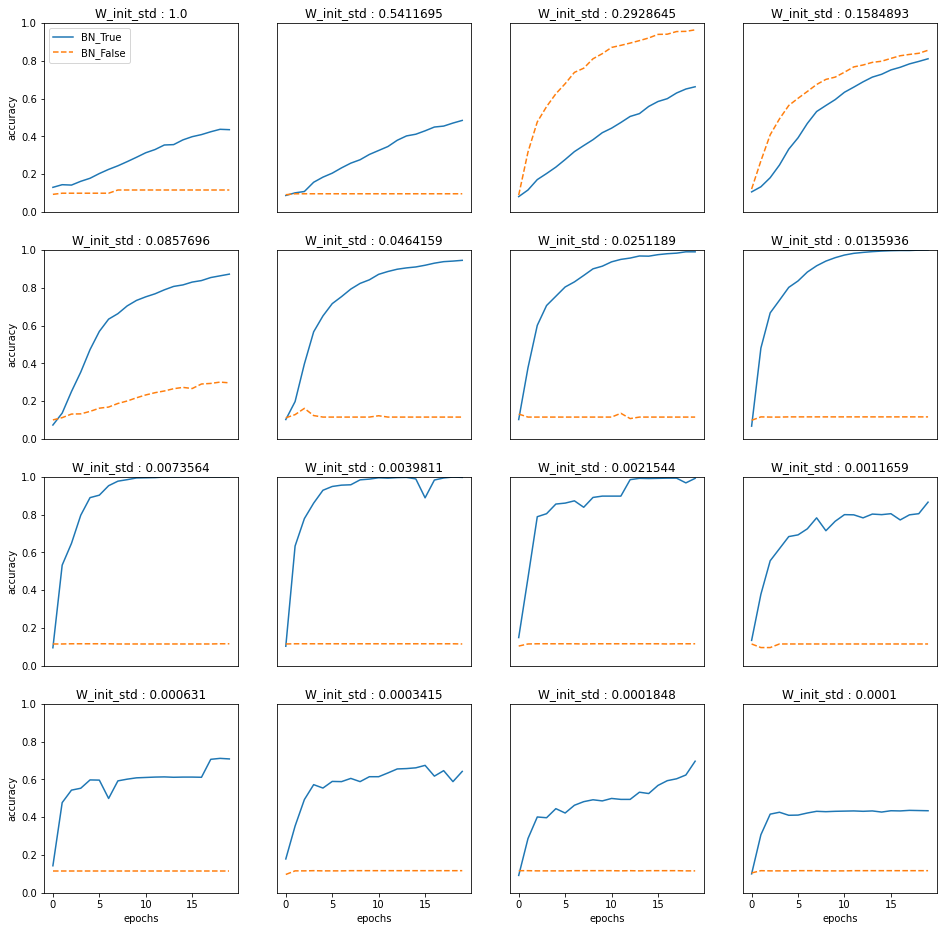

In [ ]:
# 가중치 초깃값의 표준편차 16개 
weight_scale_list = np.logspace(0, -4, num=16)
x = np.arange(max_epochs)

fig, axes = plt.subplots(4, 4, figsize=(16,16))
for i, w in enumerate(weight_scale_list): # 주어진 가중치 초기화 설정마다,
    print( "============== " + f"{i+1}/16" + " ==============")
    # 배치 정규화 여부에 따른 훈련 정확도
    train_acc_list, bn_train_acc_list = __train(w)
    # 비교 그래프
    axes[i//4,i%4].set_title(f"W_init_std : {round(w,7)}")
    if i==0:
        axes[i//4,i%4].plot(x, bn_train_acc_list, label='BN_True', markevery=2)
        axes[i//4,i%4].plot(x, train_acc_list, linestyle="--", label='BN_False', markevery=2)
        axes[i//4,i%4].legend(loc='upper left')
    else:
        axes[i//4,i%4].plot(x, bn_train_acc_list, markevery=2)
        axes[i//4,i%4].plot(x, train_acc_list, linestyle="--", markevery=2)
    axes[i//4,i%4].set_ylim(0, 1.0)
    if i%4:
        axes[i//4,i%4].set_yticks([])
    else:
        axes[i//4,i%4].set_ylabel("accuracy")
    if i<12:
        axes[i//4,i%4].set_xticks([])
    else:
        axes[i//4,i%4].set_xlabel("epochs")
plt.show()
# 배치 정규화를 수행한 신경망이 그렇지 않은 신경망에 비해 가중치 초기화 설정에 강건하고 효율적으로 학습

# 오버피팅 억제

**가중치 감소** : 손실에 가중치의 L2 norm 항 추가  
$\qquad\qquad\rightarrow$ 가중치의 크기 반영  
$\quad\qquad\qquad\rightarrow$ gradient에 의한 갱신 과정에서 각 가중치를 크기에 따라 규제(regularization)  
$\quad\quad\qquad\qquad\rightarrow$ 오버피팅 억제

**드롭아웃** : 훈련 중 은닉층 뉴런 무작위 삭제 $\rightarrow$ 표현력 보존 및 오버피팅 억제

In [ ]:
# 드롭아웃 클래스 구현
class Dropout:
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None
    
    def forward(self, x, train_flg=True):
        if train_flg: # 훈련인 경우
            self.mask = np.random.rand(*x.shape)>self.dropout_ratio
            return x * self.mask
        else: # 훈련이 아닌 경우 ; 앙상블 효과와 유사
            return x * (1.0 - self.dropout_ratio) # 테스트에서의 반환 값들이 반영되는 정도가 훈련 때와 비슷하도록 유지
    
    def backward(self, dout):
        return dout * self.mask

# 하이퍼파라미터 튜닝

**하이퍼파라미터** : 뉴런 개수, 배치 크기, 학습률, 가중치 감소의 규제 계수 등
- 검증 데이터를 통해 평가 및 조정

$\star$ 하이퍼파라미터의 최적 값에 대한 범위를 좁혀가며 탐색
1. 하이퍼파라미터 값의 범위 설정 및 랜덤 추출
2. 추출된 하이퍼파라미터로 비교적 적은 epoch을 학습 후, 검증 데이터로 평가
3. 위 두 단계의 반복을 통해 범위 축소
- **베이즈 최적화** : 베이즈 정리 기반의 수학적 이론을 통한 하이퍼파라미터 최적화

val acc : 0.12 | lr : 0.0013067441840936955, weight decay : 7.774223917336775e-07
val acc : 0.09 | lr : 0.0005965062612424645, weight decay : 6.422232190577536e-07
val acc : 0.44 | lr : 0.002150175967695128, weight decay : 3.13126602541218e-08
val acc : 0.17 | lr : 0.0018769213755269166, weight decay : 2.0722432956578357e-06
val acc : 0.09 | lr : 1.7700004721509713e-05, weight decay : 3.76822208744318e-05
val acc : 0.03 | lr : 4.1169010597364944e-05, weight decay : 1.4582889273125286e-08
val acc : 0.08 | lr : 5.592847933093217e-05, weight decay : 3.793403703137105e-05
val acc : 0.43 | lr : 0.0038600757223171194, weight decay : 1.3838640471696374e-08
val acc : 0.16 | lr : 0.0002805050857610593, weight decay : 7.38519867457636e-08
val acc : 0.09 | lr : 2.159415706093097e-06, weight decay : 9.607188008177067e-05
val acc : 0.16 | lr : 0.00016354283489217842, weight decay : 7.193880166451011e-07
val acc : 0.09 | lr : 2.3135831369248585e-05, weight decay : 5.150242864543154e-07
val acc : 0.5

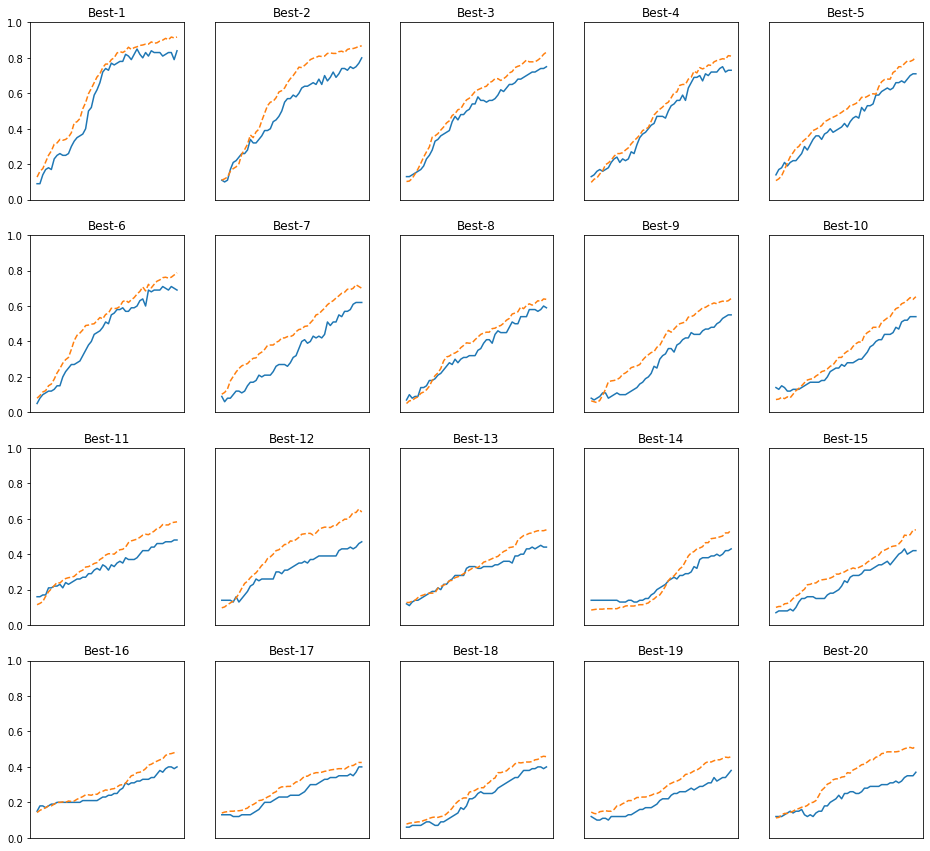

In [ ]:
# 학습률과 가중치 감소 규제 계수 튜닝 과정 구현 
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.util import shuffle_dataset
from common.trainer import Trainer # 신경망 학습 과정을 클래스로 구현
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)
# 결과를 빠르게 얻기 위해 훈련 데이터를 줄임
x_train = x_train[:500]
t_train = t_train[:500]

# 20%를 검증 데이터로 분할
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)
x_train, t_train = shuffle_dataset(x_train, t_train)
x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]

# 입력 : (학습률, 가중치 감소 규제 계수) / 반환 : (검증 정확도 추이, 훈련 정확도 추이)
def __train(lr, weight_decay, epocs=50): # 50 epoch 학습
    network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                            weight_decay_lambda=weight_decay)
    trainer = Trainer(network, x_train, t_train, x_val, t_val, epochs=epocs, mini_batch_size=100, optimizer='sgd',
                      optimizer_param={'lr': lr}, verbose=False)
    trainer.train()
    return trainer.test_acc_list, trainer.train_acc_list

# 하이퍼파라미터 무작위 탐색
optimization_trial = 100 # 100번 탐색
results_val = {}
results_train = {}
for _ in range(optimization_trial):
    # 하이퍼파라미터(가중치 감소 규제 계수, 학습률)의 각 탐색 범위로부터 랜덤 추출(균등 분포)
    weight_decay = 10 ** np.random.uniform(-8, -4) # 로그 스케일 방식
    lr = 10 ** np.random.uniform(-6, -2)

    val_acc_list, train_acc_list = __train(lr, weight_decay)
    print(f'val acc : {val_acc_list[-1]} | lr : {lr}, weight decay : {weight_decay}')
    key = f'lr : {lr}, weight decay : {weight_decay}'
    results_val[key] = val_acc_list # key는 하이퍼파라미터의 조합, value는 해당 조합에서의 학습 정확도 추이
    results_train[key] = train_acc_list

# 그래프 그리기
print("\n=========== Hyper-Parameter Optimization Result ===========")
graph_draw_num = 20
col_num = 5
row_num = int(np.ceil(graph_draw_num / col_num))

i = 0
plt.figure(figsize=(16,15))
# 최종 검증 정확도의 내림차순으로 하이퍼파라미터 조합 및 그래프 출력
for key, val_acc_list in sorted(results_val.items(), key=lambda x: x[1][-1], reverse=True):
    print(f'Best-{i+1} (val acc : {val_acc_list[-1]}) | {key}')

    plt.subplot(row_num, col_num, i+1)
    plt.title(f"Best-{i+1}")
    plt.ylim(0.0, 1.0)
    if i%5:
        plt.yticks([])
    plt.xticks([])
    x = np.arange(len(val_acc_list))
    plt.plot(x, val_acc_list)
    plt.plot(x, results_train[key], "--")
    i += 1
    if i>=graph_draw_num:
        break
plt.show()
# 아래 결과를 보고 하이퍼파라미터 최적 값의 존재 범위를 축소하여 위 과정 반복